In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna

import seaborn as sns #для визуализации

In [2]:
import warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
data = pd.read_csv('_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


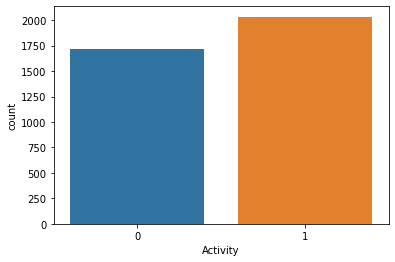

In [4]:
sns.countplot(data=data, x='Activity');

In [5]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# Обучение без подбора гиперпараметров

Логистическая регрессия

In [7]:
%%time
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78
Wall time: 2.38 s


Случайный лес

In [8]:
%%time
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.78
Wall time: 2 s


# GridSearchCV

Логистическая регрессия

In [9]:
# 2 набора параметров
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.7, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.7, 1]}
]

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state= 42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Wall time: 15min 51s
f1_score на обучающем наборе: 0.85
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Случайный лес

In [10]:
param_grid = {'n_estimators': [100, 200, 300],
              'min_samples_leaf': [3, 4, 5, 6, 7],
              'max_depth': list(np.linspace(15, 25, 11, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=42),
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time grid_search.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Wall time: 20min 5s
f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 3, 'n_estimators': 200}


# RandomizedSearchCV

Логистическая регрессия

In [11]:
# 2 набора параметров
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.7, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.7, 1]}
]
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions = param_grid, 
    cv=5, 
    n_iter = 25, 
    n_jobs = -1
)  
 
 
%time random_search.fit(X_train, y_train) 

y_train_pred = random_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

Wall time: 9min 49s
f1_score на обучающем наборе: 0.85
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.1}


Случайный лес

In [12]:
param_grid = {'n_estimators': [100, 200, 300],
              'min_samples_leaf': [3, 4, 5, 6, 7],
              'max_depth': list(np.linspace(15, 25, 11, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions = param_grid, 
    cv=5,
    n_iter = 25, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 

y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

Wall time: 1min 46s
f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'n_estimators': 200, 'min_samples_leaf': 3, 'max_depth': 18, 'criterion': 'entropy'}


# Hyperopt

Логистическая регрессия

In [13]:
space_1 = {'penalty': hp.choice('penalty', ['l1', 'l2']),
       'solver' : hp.choice('solver', ['liblinear', 'saga']),
       'C': hp.uniform('C', 0.01, 1)
      }

In [14]:
space_2 = {'penalty': hp.choice('penalty', ['l2', 'none']),
       'solver' : hp.choice('solver', ['lbfgs', 'sag']),
       'C': hp.uniform('C', 0.01, 1)
      }

In [15]:
random_state = 42
def hyperopt_log_reg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'],
              'solver' :  params['solver'],
              'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=1000)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))

    return -score

In [16]:
%%time
# первый набор параметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_log_reg, # наша функция 
          space=space_1, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [05:03<00:00, 15.19s/trial, best loss: -0.8825688073394496]
Наилучшие значения гиперпараметров {'C': 0.9195352964526831, 'penalty': 1, 'solver': 0}
Wall time: 5min 3s


In [17]:
model = linear_model.LogisticRegression(
    random_state=random_state, 
    max_iter = 1000,
    penalty = 'l2',
    solver = 'liblinear',
    C = best['C']
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.88
f1_score на тестовом наборе: 0.78


In [18]:
%%time
# второй набор параметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_log_reg, # наша функция 
          space=space_2, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [04:31<00:00, 13.57s/trial, best loss: -0.9935563056152193]
Наилучшие значения гиперпараметров {'C': 0.7304484857455518, 'penalty': 1, 'solver': 0}
Wall time: 4min 31s


In [19]:
model = linear_model.LogisticRegression(
    random_state=random_state, 
    max_iter = 1000,
    penalty = 'none',
    solver = 'lbfgs',
    C = best['C']
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.72


Добавляем кросс-валидацию к лучшему варианту

In [20]:
def hyperopt_log_reg(params, cv=10, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'],
              'solver' :  params['solver'],
              'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=1000)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [21]:
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_log_reg, # наша функция 
          space=space_1, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [26:06<00:00, 78.34s/trial, best loss: -0.7858740304909678]
Наилучшие значения гиперпараметров {'C': 0.023051205281475296, 'penalty': 1, 'solver': 0}
Wall time: 26min 6s


In [22]:
model = linear_model.LogisticRegression(
    random_state=random_state, 
    max_iter = 1000,
    penalty = 'l2',
    solver = 'liblinear',
    C = best['C']
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.79


Случайный лес

In [23]:
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 9, 1),
       'criterion' : hp.choice('criterion', ['entropy','gini'])
      }

In [24]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'min_samples_leaf': int(params['min_samples_leaf']),
              'criterion': params['criterion']
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [25]:
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [01:00<00:00,  3.01s/trial, best loss: -0.9935563056152193]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 210.0}
Wall time: 1min


In [26]:
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']),
    criterion = 'entropy'
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.83


Добавляем кросс-валидацию

In [27]:
def hyperopt_rf(params, cv=10, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'min_samples_leaf': int(params['min_samples_leaf']),
              'criterion': params['criterion']
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
  
    return -score

In [28]:
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [04:12<00:00, 12.60s/trial, best loss: -0.8123338868477779]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 18.0, 'min_samples_leaf': 3.0, 'n_estimators': 200.0}
Wall time: 4min 12s


In [29]:
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']),
    criterion = 'entropy'
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.82


# Optuna

Логистическая регрессия

In [30]:
space_1 = {'penalty': hp.choice('penalty', ['l1', 'l2']),
       'solver' : hp.choice('solver', ['liblinear', 'saga']),
       'C': hp.uniform('C', 0.01, 1)
      }
space_2 = {'penalty': hp.choice('penalty', ['l2', 'none']),
       'solver' : hp.choice('solver', ['lbfgs', 'sag']),
       'C': hp.uniform('C', 0.01, 1)
      }

In [31]:
# первый набор параметров
def optuna_log_reg(trial):
  # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_uniform('C', 0.01, 1)

    # создаем модель
    model = linear_model.LogisticRegression(penalty = penalty,
                                          solver = solver,
                                          C = C,
                                          random_state=random_state,
                                          max_iter = 1000)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [32]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_log_reg, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2022-06-15 21:51:17,619] A new study created in memory with name: LogisticRegression
[I 2022-06-15 21:51:18,196] Trial 0 finished with value: 0.8651616839536302 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.23693473046035649}. Best is trial 0 with value: 0.8651616839536302.
[I 2022-06-15 21:51:18,645] Trial 1 finished with value: 0.8541856925418571 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.6097584376577737}. Best is trial 0 with value: 0.8651616839536302.
[I 2022-06-15 21:52:22,475] Trial 2 finished with value: 0.8600182982616652 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.7694168696932184}. Best is trial 0 with value: 0.8651616839536302.
[I 2022-06-15 21:52:42,045] Trial 3 finished with value: 0.8711355984083258 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.4169692400149647}. Best is trial 3 with value: 0.8711355984083258.
[I 2022-06-15 21:52:42,315] Trial 4 finished with value: 0.8255884127942064 and parameters: {

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'saga', 'C': 0.9890081876584274}
Wall time: 7min 44s


In [33]:
model = linear_model.LogisticRegression(
    **study.best_params,
    random_state=random_state, 
    max_iter = 1000,
   )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.88
f1_score на тестовом наборе: 0.78


In [34]:
# второй набор параметров
def optuna_log_reg(trial):
  # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
    C = trial.suggest_uniform('C', 0.01, 1)

    # создаем модель
    model = linear_model.LogisticRegression(penalty = penalty,
                                          solver = solver,
                                          C = C,
                                          random_state=random_state,
                                          max_iter = 1000)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [35]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_log_reg, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2022-06-15 21:59:35,477] A new study created in memory with name: LogisticRegression
[I 2022-06-15 21:59:39,922] Trial 0 finished with value: 0.9935563056152193 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.3471778057488027}. Best is trial 0 with value: 0.9935563056152193.
[I 2022-06-15 21:59:41,727] Trial 1 finished with value: 0.8816151728357297 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.858304457050198}. Best is trial 0 with value: 0.9935563056152193.
[I 2022-06-15 22:00:25,660] Trial 2 finished with value: 0.925993883792049 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.8787821355230475}. Best is trial 0 with value: 0.9935563056152193.
[I 2022-06-15 22:00:30,100] Trial 3 finished with value: 0.9935563056152193 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.49948141608156066}. Best is trial 0 with value: 0.9935563056152193.
[I 2022-06-15 22:01:13,833] Trial 4 finished with value: 0.925993883792049 and parameters: {'pena

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.3471778057488027}
Wall time: 4min 31s


In [36]:
model = linear_model.LogisticRegression(
    **study.best_params,
    random_state=random_state, 
    max_iter = 1000,
   )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.72


Добавляем кросс-валидацию к лучшему варианту

In [37]:
def optuna_log_reg(trial):
  # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_uniform('C', 0.01, 1)

    # создаем модель
    model = linear_model.LogisticRegression(penalty = penalty,
                                          solver = solver,
                                          C = C,
                                          random_state=random_state,
                                          max_iter = 1000)
    # обучаем модель
    model.fit(X_train, y_train)
    score = cross_val_score(model, X, y, cv = 5, scoring="f1", n_jobs=-1).mean()

    return score

In [38]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_log_reg, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2022-06-15 22:04:11,196] A new study created in memory with name: LogisticRegression
[I 2022-06-15 22:04:16,007] Trial 0 finished with value: 0.7787167932268604 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.40801642461686727}. Best is trial 0 with value: 0.7787167932268604.
[I 2022-06-15 22:04:19,482] Trial 1 finished with value: 0.7778904868285228 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.5297827906151193}. Best is trial 0 with value: 0.7787167932268604.
[I 2022-06-15 22:08:48,532] Trial 2 finished with value: 0.7811400841492298 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.7332756078096175}. Best is trial 2 with value: 0.7811400841492298.
[I 2022-06-15 22:09:43,139] Trial 3 finished with value: 0.7765825334938941 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.0762016983548719}. Best is trial 2 with value: 0.7811400841492298.
[I 2022-06-15 22:11:35,684] Trial 4 finished with value: 0.7792525567702718 and parameters: {

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.22231172765636362}
Wall time: 34min 49s


In [39]:
model = linear_model.LogisticRegression(
    **study.best_params,
    random_state=random_state, 
    max_iter = 1000,
   )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.78


Случайный лес

In [40]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators',  100, 300, 10)
    max_depth = trial.suggest_int('max_depth', 15, 26, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 9, 1)
    criterion = trial.suggest_categorical('criterion', ['entropy','gini'])

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators = n_estimators,
                                          max_depth = max_depth,
                                          min_samples_leaf = min_samples_leaf,
                                          criterion = criterion,
                                          random_state = random_state)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [41]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2022-06-15 22:39:39,347] A new study created in memory with name: RandomForestClassifier
[I 2022-06-15 22:39:43,264] Trial 0 finished with value: 0.9605142332415059 and parameters: {'n_estimators': 270, 'max_depth': 15, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9605142332415059.
[I 2022-06-15 22:39:46,013] Trial 1 finished with value: 0.988653787181846 and parameters: {'n_estimators': 170, 'max_depth': 16, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.988653787181846.
[I 2022-06-15 22:39:49,314] Trial 2 finished with value: 0.9557522123893805 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.988653787181846.
[I 2022-06-15 22:39:52,718] Trial 3 finished with value: 0.9929382867669635 and parameters: {'n_estimators': 200, 'max_depth': 22, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 3 with value: 0.9929382867669635.
[I 202

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 22, 'min_samples_leaf': 2, 'criterion': 'entropy'}
Wall time: 1min


In [42]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82


Добавляем кросс-валидацию

In [43]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators',  100, 300, 10)
    max_depth = trial.suggest_int('max_depth', 15, 26, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 9, 1)
    criterion = trial.suggest_categorical('criterion', ['entropy','gini'])

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators = n_estimators,
                                          max_depth = max_depth,
                                          min_samples_leaf = min_samples_leaf,
                                          criterion = criterion,
                                          random_state = random_state)
    # обучаем модель
    model.fit(X_train, y_train)
    score = cross_val_score(model, X, y, cv = 5, scoring="f1", n_jobs=-1).mean()

    return score

In [44]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2022-06-15 22:40:43,171] A new study created in memory with name: RandomForestClassifier
[I 2022-06-15 22:40:47,078] Trial 0 finished with value: 0.8020446312971636 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8020446312971636.
[I 2022-06-15 22:41:00,055] Trial 1 finished with value: 0.8006026236419806 and parameters: {'n_estimators': 300, 'max_depth': 24, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.8020446312971636.
[I 2022-06-15 22:41:04,882] Trial 2 finished with value: 0.8005877903853895 and parameters: {'n_estimators': 150, 'max_depth': 16, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.8020446312971636.
[I 2022-06-15 22:41:09,812] Trial 3 finished with value: 0.8030935019343112 and parameters: {'n_estimators': 140, 'max_depth': 20, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 3 with value: 0.8030935019343112.
[I 2022-0

Наилучшие значения гиперпараметров {'n_estimators': 220, 'max_depth': 26, 'min_samples_leaf': 2, 'criterion': 'gini'}
Wall time: 2min 40s


In [45]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82


# Сравнение методов оптимизации гиперпараметров

In [47]:
comparison = pd.DataFrame([[0.78,'2.38 s',0.79, '15min 51s',0.79,'9min 49s',0.78,'5min 3s',0.79,'26min 6s',0.78,'7min 44s',0.78,'34min 49s'
],[0.78,'2 s',0.82,'20min 5s',0.79,'1min 46s',0.83,'1min',0.82,'4min 12s',0.82,'1min',0.82,'2min 40s']],
    index=['LogReg','RandomForest'],
    columns=[['Basic','Basic','GridSearchCV','GridSearchCV', 'RandomizedSearchCV', 'RandomizedSearchCV', 'Hyperopt', 'Hyperopt', 'Hyperopt+CV', 'Hyperopt+CV', 'Optuna', 'Optuna', 'Optuna+CV', 'Optuna+CV'],
             ['f1_score', 'time','f1_score', 'time','f1_score', 'time','f1_score', 'time','f1_score', 'time','f1_score', 'time','f1_score', 'time']])
comparison

Basic         GridSearchCV            RandomizedSearchCV  \
             f1_score    time     f1_score       time           f1_score   
LogReg           0.78  2.38 s         0.79  15min 51s               0.79   
RandomForest     0.78     2 s         0.82   20min 5s               0.79   

                       Hyperopt          Hyperopt+CV             Optuna  \
                  time f1_score     time    f1_score      time f1_score   
LogReg        9min 49s     0.78  5min 3s        0.79  26min 6s     0.78   
RandomForest  1min 46s     0.83     1min        0.82  4min 12s     0.82   

                       Optuna+CV             
                  time  f1_score       time  
LogReg        7min 44s      0.78  34min 49s  
RandomForest      1min      0.82   2min 40s

1. Наилучший f1_score: 0.83 (RandomForest, гиперпараметры {'criterion': 0, 'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 210.0}, подобраны с помощью Hyperopt).
2. Подбор параметров и обучение модели случайного леса проходит стабильно быстрее по сравнению с логистической регрессией.
3. Кросс-валидация существенно увеличивает время подбора параметров и обучения, и лишь в одном случае из четырех для данной задаче позволила улучшить значение метрики.